# Logistic Regression

In [21]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42

## Feature Engineering

In [3]:
# Constant
drop_cols = ["Name", "SibSp", "Parch", "Ticket"]
obj_col = "Survived"
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

## feature engineering
def feature_engineering(raw_df):
    df = raw_df.copy()
    df["Cabin"] = df["Cabin"].apply(lambda x: x[:1] if x is not np.nan else np.nan)
    df["Ticket"] = df["Ticket"].apply(lambda x: str(x).split()[0])
    df["Family"] = df["SibSp"] + df["Parch"]
    return df

In [4]:
# cat
def to_category(train_df, test_df):
    cat = ["Sex", "Cabin", "Embarked"]
    mappings = {}
    for col in cat:
        le = preprocessing.LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return train_df, test_df, mappings

In [5]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions  = 1*(y_proba >= t)
    return y_proba, predictions

## Metrics and Plots

In [6]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

In [7]:
def get_metrics(y, ypred, yproba):
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [8]:
def get_plots(y, ypred, yproba):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm).plot()
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [9]:
# evaluation
def eval_model(clf, X, y):
    y_proba, y_pred = get_predictions(clf, X)
    metrics =  get_metrics(y, y_pred, y_proba)
    plots = get_plots(y, y_pred, y_proba)
    return metrics, plots

## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation. 

In [10]:
print("Loading data...")
df_train = pd.read_csv(train_df_path, index_col="PassengerId")
df_test = pd.read_csv(test_df_path, index_col="PassengerId")

print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
train_df, test_df, mappings = to_category(train_df, test_df)

Loading data...
Engineering features...


Here are the features in the data:

```
survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

In [11]:
mappings

{'Sex': {'female': 0, 'male': 1},
 'Cabin': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'T': 7,
  nan: 8},
 'Embarked': {'C': 0, 'Q': 1, 'S': 2, nan: 3}}

## Some EDA

In [12]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


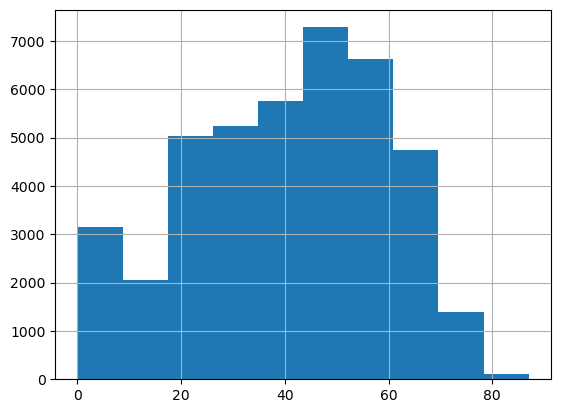

In [13]:
df_train[df_train.Survived==1].Age.hist()
plt.show()

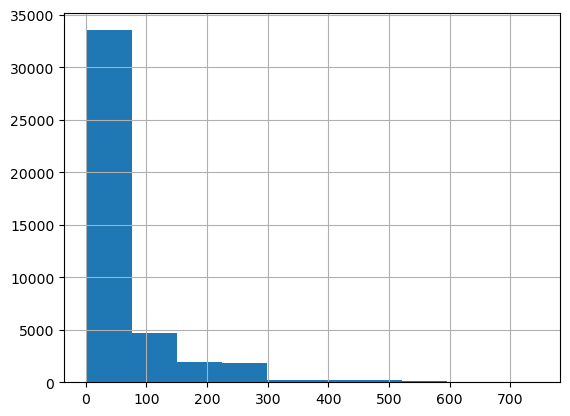

In [14]:
df_train[df_train.Survived==1].Fare.hist()
plt.show()

In [15]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [16]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [17]:
train_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,
0,1,1,0.00,27.14,2,2,2
1,3,1,0.00,13.35,8,2,0
2,3,1,0.33,71.29,8,2,3
3,3,1,19.00,13.04,8,2,0
4,3,1,25.00,7.76,8,2,0


In [18]:
train_df.describe()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
count,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.106910,0.56114,37.09281,43.870465,5.983550,1.504520,0.852250
std,0.837727,0.49625,19.26607,69.560745,3.023404,0.835899,1.412792
min,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.00000,24.00000,10.020000,2.000000,1.000000,0.000000
50%,2.000000,1.00000,38.00000,24.440000,8.000000,2.000000,0.000000
75%,3.000000,1.00000,53.00000,33.470000,8.000000,2.000000,1.000000
max,3.000000,1.00000,87.00000,744.660000,8.000000,3.000000,17.000000


In [19]:
for col in ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Family']:
    print(col, train_df[col].unique())

Pclass [1 3 2]
Sex [1 0]
Cabin [2 8 0 3 1 4 5 6 7]
Embarked [2 0 1 3]
Family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


## Now train with systematic hyperparameters

In [26]:
print("Training model...")
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

Training model...


In [30]:
def fit_model(train_X, train_y, C=1, random_state=42):
    clf = LogisticRegression(C=C, solver='liblinear')
    clf.fit(train_X, train_y)
    return clf

In [31]:
import uuid

In [32]:
metrics = []
for cval in [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]:
    run_id = uuid.uuid4()
    print(f"Training Model {cval}")
    model = fit_model(X_train, y_train, C=cval)
    print("Evaluating Model")
    train_metrics, train_plots = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_metrics)
    train_metrics['data'] = 'train'
    train_metrics['C'] = cval
    train_metrics['run_id'] = run_id
    metrics.append(train_metrics)
    for k in train_plots:
        train_plots[k].figure_.savefig(f"plots/lr_train_{run_id}_{k}.png")
    test_metrics, test_plots = eval_model(model, X_test, y_test)
    print("Test metrics:")
    print(test_metrics)
    test_metrics['data'] = 'test'
    test_metrics['C'] = cval
    test_metrics['run_id'] = run_id
    metrics.append(test_metrics)
    for k in test_plots:
        test_plots[k].figure_.savefig(f"plots/lr_test_{run_id}_{k}.png")
    joblib.dump(model, f"models/lr_{run_id}.joblib")
    print('----------------------')

Training Model 0.001
Evaluating Model
Train metrics:
{'roc_auc': 0.8192103276694458, 'average_precision': 0.75643976991039, 'accuracy': 0.7532089552238806, 'precision': 0.7445932859909619, 'recall': 0.6439163962455076, 'f1': 0.6906049435847538, 'cm': array([[32011,  6330],
       [10205, 18454]])}
Test metrics:
{'roc_auc': 0.8200313454545386, 'average_precision': 0.7544153555644639, 'accuracy': 0.749030303030303, 'precision': 0.7386856534904657, 'recall': 0.6394615657102374, 'f1': 0.685501632870054, 'cm': array([[15692,  3193],
       [ 5089,  9026]])}
----------------------
Training Model 0.01
Evaluating Model
Train metrics:
{'roc_auc': 0.825440006687788, 'average_precision': 0.7655911640795543, 'accuracy': 0.7642537313432836, 'precision': 0.7281660163178432, 'recall': 0.716249694685788, 'f1': 0.7221587011205122, 'cm': array([[30678,  7663],
       [ 8132, 20527]])}
Test metrics:
{'roc_auc': 0.8268775408627137, 'average_precision': 0.7653545684863521, 'accuracy': 0.7630606060606061, '

In [33]:
resudf = pd.DataFrame.from_records(metrics).set_index('run_id')
resudf

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,C
run_id,,,,,,,,,
dc60935a-2113-4cb0-8cbd-eae1964711dc,0.819210,0.756440,0.753209,0.744593,0.643916,0.690605,"[[32011, 6330], [10205, 18454]]",train,0.001
dc60935a-2113-4cb0-8cbd-eae1964711dc,0.820031,0.754415,0.749030,0.738686,0.639462,0.685502,"[[15692, 3193], [5089, 9026]]",test,0.001
503bbb58-9bc1-4b94-822a-9ad4a603b1b5,0.825440,0.765591,0.764254,0.728166,0.716250,0.722159,"[[30678, 7663], [8132, 20527]]",train,0.010
503bbb58-9bc1-4b94-822a-9ad4a603b1b5,0.826878,0.765355,0.763061,0.726410,0.715551,0.720939,"[[15081, 3804], [4015, 10100]]",test,0.010
35d39f61-4770-4ae1-a9b3-fcdf991473b3,0.825284,0.766421,0.765985,0.722550,0.735232,0.728836,"[[30250, 8091], [7588, 21071]]",train,0.100
35d39f61-4770-4ae1-a9b3-fcdf991473b3,0.826841,0.766417,0.765394,0.722195,0.733758,0.727931,"[[14901, 3984], [3758, 10357]]",test,0.100
2f958bbb-fcc7-4d05-881e-bd94d4e27fac,0.825238,0.766545,0.766313,0.722454,0.736697,0.729506,"[[30230, 8111], [7546, 21113]]",train,1.000
2f958bbb-fcc7-4d05-881e-bd94d4e27fac,0.826894,0.766638,0.765364,0.721990,0.734113,0.728001,"[[14895, 3990], [3753, 10362]]",test,1.000
18b25bda-be52-4b86-9c31-513e9b0faa20,0.825232,0.766551,0.766254,0.722447,0.736488,0.729400,"[[30232, 8109], [7552, 21107]]",train,10.000


In [34]:
resudf.to_csv("results/results_lr.csv", header=True)